**FCNN 4 bands**

Dataset

In [16]:
import sys
sys.path.append("..")
sys.path.append("..")

from src import dataset_4bands as dataset
from src import metadata, dataset_pv
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import torch
from torch import nn
from torch.utils.data import DataLoader

from tqdm import tqdm
import torch.nn.functional as F
from torch.nn import MSELoss
from torch.optim import Adam
import time

from torchsummary import summary

import optuna

In [17]:
df_s2 = metadata.process_metadata("/media/disk/databases/cloudsen12/high/hq_data.csv")

df_s2 = df_s2.reset_index()
df_s2

,index,user,ROI,sen2,cloud_per,cloud_coverage,sensing_time,year,path
0,0,ANDREA,point_0317,20190207T172509_20190207T173213_T13QGG,0.0,cloud-free,2019-02-07 17:25:09+00:00,2019,/media/disk/databases/cloudsen12/high/point_03...
1,5,ANDREA,point_0320,20190409T164849_20190409T165500_T16UGD,0.0,cloud-free,2019-04-09 16:48:49+00:00,2019,/media/disk/databases/cloudsen12/high/point_03...
2,10,ANDREA,point_0323,20200407T222531_20200407T222530_T04WDS,0.0,cloud-free,2020-04-07 22:25:31+00:00,2020,/media/disk/databases/cloudsen12/high/point_03...
3,15,ANDREA,point_0329,20190114T101351_20190114T102032_T31PDP,0.0,cloud-free,2019-01-14 10:13:51+00:00,2019,/media/disk/databases/cloudsen12/high/point_03...
4,20,ANDREA,point_0332,20190127T070141_20190127T071456_T39NTJ,0.0,cloud-free,2019-01-27 07:01:41+00:00,2019,/media/disk/databases/cloudsen12/high/point_03...
...,...,...,...,...,...,...,...,...,...
1995,9975,WENDY,point_9969,20190327T054641_20190327T055021_T43RCQ,0.0,cloud-free,2019-03-27 05:46:41+00:00,2019,/media/disk/databases/cloudsen12/high/point_99...
1996,9980,WENDY,point_9976,20181217T055231_20181217T055231_T43SDR,0.0,cloud-free,2018-12-17 05:52:31+00:00,2018,/media/disk/databases/cloudsen12/high/point_99...
1997,9985,WENDY,point_9980,20181217T055231_20181217T055231_T42SYA,0.0,cloud-free,2018-12-17 05:52:31+00:00,2018,/media/disk/databases/cloudsen12/high/point_99...
1998,9990,WENDY,point_9981,20181217T055231_20181217T055231_T42SYA,0.0,cloud-free,2018-12-17 05:52:31+00:00,2018,/media/disk/databases/cloudsen12/high/point_99...


In [18]:
df_pv = metadata.process_metadata("/media/disk/databases/cloudsen12/highprobav/processed_probav.csv")
df_pv

,ROI,user,sen2,cloud_per,cloud_coverage,sensing_time,year,path,bounds_latlong,bounds,crs_chips,geometry,center_latlong,PV100TOC,PV100TOA,PV_diff_days,PV_frac_invalids,PV_frac_clouds,missing
0,point_0317,ANDREA,20190207T172509_20190207T173213_T13QGG,0.0,cloud-free,2019-02-07 17:25:09+00:00,2019,/media/disk/databases/cloudsen12/highprobav/po...,"(-102.33019815388593, 24.313454163761712, -102...","BoundingBox(left=770950.0, bottom=2691630.0, r...",EPSG:32613,POLYGON ((-102.33019815388593 24.3134541637617...,"(-102.30465226392862, 24.336860226798464)",PROBAV_S1_TOC_X07Y05_20190209_100M_V101.HDF5,PROBAV_S1_TOA_X07Y05_20190209_100M_V101.HDF5,2.0,0.000000,0.157719,False
1,point_0320,ANDREA,20190409T164849_20190409T165500_T16UGD,0.0,cloud-free,2019-04-09 16:48:49+00:00,2019,/media/disk/databases/cloudsen12/highprobav/po...,"(-83.8758104013502, 52.4839623391974, -83.7976...","BoundingBox(left=712120.0, bottom=5819680.0, r...",EPSG:32616,"POLYGON ((-83.8758104013502 52.4839623391974, ...","(-83.83672824372164, 52.50780920150713)",PROBAV_S1_TOC_X09Y02_20190410_100M_V101.HDF5,PROBAV_S1_TOA_X09Y02_20190410_100M_V101.HDF5,1.0,0.000000,0.929783,False
2,point_0323,ANDREA,20200407T222531_20200407T222530_T04WDS,0.0,cloud-free,2020-04-07 22:25:31+00:00,2020,/media/disk/databases/cloudsen12/highprobav/po...,"(-159.79539236149657, 64.77396032968922, -159....","BoundingBox(left=462240.0, bottom=7183500.0, r...",EPSG:32604,POLYGON ((-159.79539236149657 64.7739603296892...,"(-159.74120686918297, 64.79706207184097)",PROBAV_S1_TOC_X02Y01_20200406_100M_V101.HDF5,PROBAV_S1_TOA_X02Y01_20200406_100M_V101.HDF5,-1.0,0.099609,0.900391,False
3,point_0329,ANDREA,20190114T101351_20190114T102032_T31PDP,0.0,cloud-free,2019-01-14 10:13:51+00:00,2019,/media/disk/databases/cloudsen12/highprobav/po...,"(2.261778764637082, 12.234735220472697, 2.3087...","BoundingBox(left=419720.0, bottom=1352620.0, r...",EPSG:32631,POLYGON ((2.261778764637082 12.234735220472697...,"(2.285240232661488, 12.257809363657463)",PROBAV_S1_TOC_X18Y06_20190114_100M_V101.HDF5,PROBAV_S1_TOA_X18Y06_20190114_100M_V101.HDF5,0.0,0.000000,0.000000,False
4,point_0332,ANDREA,20190127T070141_20190127T071456_T39NTJ,0.0,cloud-free,2019-01-27 07:01:41+00:00,2019,/media/disk/databases/cloudsen12/highprobav/po...,"(48.77810415711981, 7.734263085540499, 48.8244...","BoundingBox(left=254960.0, bottom=855560.0, ri...",EPSG:32639,"POLYGON ((48.77810415711981 7.734263085540499,...","(48.801287685585876, 7.757386441728896)",PROBAV_S1_TOC_X22Y06_20190127_100M_V101.HDF5,PROBAV_S1_TOA_X22Y06_20190127_100M_V101.HDF5,0.0,0.000000,0.000000,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1995,point_9969,WENDY,20190327T054641_20190327T055021_T43RCQ,0.0,cloud-free,2019-03-27 05:46:41+00:00,2019,/media/disk/databases/cloudsen12/highprobav/po...,"(73.1428297673523, 30.83039542287769, 73.19691...","BoundingBox(left=322460.0, bottom=3412280.0, r...",EPSG:32643,"POLYGON ((73.1428297673523 30.83039542287769, ...","(73.16987025227952, 30.85372441757002)",PROBAV_S1_TOC_X25Y04_20190326_100M_V101.HDF5,PROBAV_S1_TOA_X25Y04_20190326_100M_V101.HDF5,-1.0,0.000000,0.352837,False
1996,point_9976,WENDY,20181217T055231_20181217T055231_T43SDR,0.0,cloud-free,2018-12-17 05:52:31+00:00,2018,/media/disk/databases/cloudsen12/highprobav/po...,"(74.17119907381326, 32.172166988823975, 74.225...","BoundingBox(left=421900.0, bottom=3559820.0, r...",EPSG:32643,POLYGON ((74.17119907381326 32.172166988823975...,"(74.19839903147333, 32.195295680860795)",PROBAV_S1_TOC_X25Y04_20181217_100M_V101.HDF5,PROBAV_S1_TOA_X25Y04_20181217_100M_V101.HDF5,0.0,1.000000,0.000000,False
1997,point_9980,WENDY,20181217T055231_20181217T055231_T42SYA,0.0,cloud-free,2018-12-17 05:52:31+00:00,2018,/media/disk/databases/cloudsen12/highprobav/po...,"(72.05048765833794, 31.77290206935128, 72.1057...","BoundingBox(left=788900.0, bottom=3519460.0, r...",EPSG:32642,"POLYGON ((72.05048765833794 31.77290206935128,...","(72.07809412765002, 31.79647972

In [19]:
df_s2['cloud_coverage'].unique()

array(['cloud-free'], dtype=object)

In [20]:
df_pv[df_pv['missing'] == False].isnull().sum()

ROI                 0
user                0
sen2                0
cloud_per           0
cloud_coverage      0
sensing_time        0
year                0
path                0
bounds_latlong      0
bounds              0
crs_chips           0
geometry            0
center_latlong      0
PV100TOC            0
PV100TOA            0
PV_diff_days        0
PV_frac_invalids    0
PV_frac_clouds      0
missing             0
dtype: int64

In [21]:
df_pv.isnull().sum()

ROI                   0
user                  0
sen2                  0
cloud_per             0
cloud_coverage        0
sensing_time          0
year                  0
path                  0
bounds_latlong        0
bounds                0
crs_chips             0
geometry              0
center_latlong        0
PV100TOC            100
PV100TOA            100
PV_diff_days        100
PV_frac_invalids    119
PV_frac_clouds      119
missing               0
dtype: int64

In [22]:
np.sum(df_pv['PV100TOC'].isnull() != df_pv['PV100TOA'].isnull())

0

In [23]:
df_pv['PV_frac_clouds'].unique()

array([1.57718658e-01, 9.29782867e-01, 9.00390625e-01, ...,
       4.88601685e-01, 3.52836609e-01, 7.82012939e-04])

In [24]:
df_pv['PV_frac_invalids'].unique()

array([0.00000000e+00, 9.96093750e-02, 1.00000000e+00, 1.99737549e-02,
       4.18224335e-01, 1.01661682e-02, 1.48437500e-01,            nan,
       5.85937500e-03, 5.65601349e-01, 3.84544373e-01, 1.95312500e-03,
       7.72926331e-01, 1.56818390e-01, 2.18799591e-01, 2.14309692e-01,
       9.71778870e-01, 9.98676300e-01, 2.73437500e-02, 2.21023560e-02,
       1.35803223e-03, 1.79687500e-01, 1.03786469e-01, 8.59375000e-02,
       6.17591858e-01, 7.99942017e-03, 5.42987823e-01, 4.39010620e-01,
       1.73828125e-01, 2.06565857e-02, 1.69921875e-01, 1.86561584e-01,
       3.00781250e-01, 3.35937500e-01, 2.66647339e-02, 7.71377563e-01,
       4.07028198e-03, 6.36550903e-01, 5.87680817e-01, 4.60182190e-01,
       9.79251862e-01, 3.16196442e-01, 4.23686981e-01, 8.86756897e-01,
       6.97978973e-01, 4.21875000e-01, 1.50390625e-01, 1.25427246e-01,
       7.07473755e-02, 6.09947205e-01, 3.84765625e-01, 6.33007050e-01,
       2.63973236e-01, 1.75781250e-02, 3.71093750e-02, 6.64062500e-02,
      

In [25]:
#train-test split

points = ['point_0502', 'point_0523', 'point_0537', 'point_0588', 'point_0645', 'point_0842',
               'point_0845', 'point_0882', 'point_0916', 'point_0917', 'point_0944', 'point_0983',
               'point_0992', 'point_10634', 'point_11224', 'point_11337', 'point_11588', 'point_0110',
               'point_0155', 'point_0188', 'point_0278', 'point_0322', 'point_0434', 'point_0521', 'point_0542',
               'point_0792', 'point_1302', 'point_1357', 'point_1385', 'point_1398', 'point_1771', 'point_0036',
               'point_0165', 'point_0267', 'point_0357', 'point_0399', 'point_0474', 'point_0483', 'point_0498',
               'point_0557', 'point_0562', 'point_0563', 'point_1019', 'point_1028', 'point_1043', 'point_1061',
               'point_1068', 'point_1084', 'point_1099', 'point_1124', 'point_11274', 'point_0028', 'point_0037',
               'point_0142', 'point_0214', 'point_0286', 'point_0313', 'point_0373', 'point_0487', 'point_1208',
               'point_1238', 'point_1244', 'point_1273', 'point_1276', 'point_1277', 'point_1290', 'point_1296',
               'point_11862', 'point_11920', 'point_12023', 'point_2972', 'point_3153', 'point_8099', 'point_2088',
               'point_2421', 'point_2446', 'point_2755', 'point_3400', 'point_6317', 'point_6464', 'point_6543',
               'point_6869', 'point_7355', 'point_7445', 'point_8402', 'point_9054', 'point_0800', 'point_0812',
               'point_0820', 'point_0822', 'point_0823', 'point_4211', 'point_4325', 'point_3848', 'point_3897',
               'point_4140', 'point_4495', 'point_5786', 'point_0290', 'point_3316']

test_samples_s2 = [item in points for item in df_s2['ROI']]

df_test = df_s2[test_samples_s2]
df_train = df_s2.loc[~df_s2.index.isin(df_test.index)]

In [26]:
#train-test split

test_samples_pv = [item in points for item in df_pv['ROI']]

df_pv_test = df_pv[test_samples_pv]
df_pv_train = df_pv.loc[~df_pv.index.isin(df_pv_test.index)]

In [27]:
len(df_train), len(df_test), len(df_pv_train), len(df_pv_test)

(1900, 100, 1900, 100)

In [28]:
print(any(item in df_test.index for item in df_train.index))
print(any(item in df_pv_test.index for item in df_pv_train.index))

False
False


In [29]:
ds_train = dataset.TiffDataset(df_train, 256, False)
print(len(ds_train))
ds_pv_train = dataset_pv.TiffDataset(df_pv_train, 256, False)
print(len(ds_pv_train))

1900
1900


In [30]:
ds_test = dataset.TiffDataset(df_test, 256, False)
print(len(ds_test))
ds_pv_test = dataset_pv.TiffDataset(df_pv_test, 256, False)
print(len(ds_pv_test))

100
100


98


Text(0.5, 1.0, 'L2A')

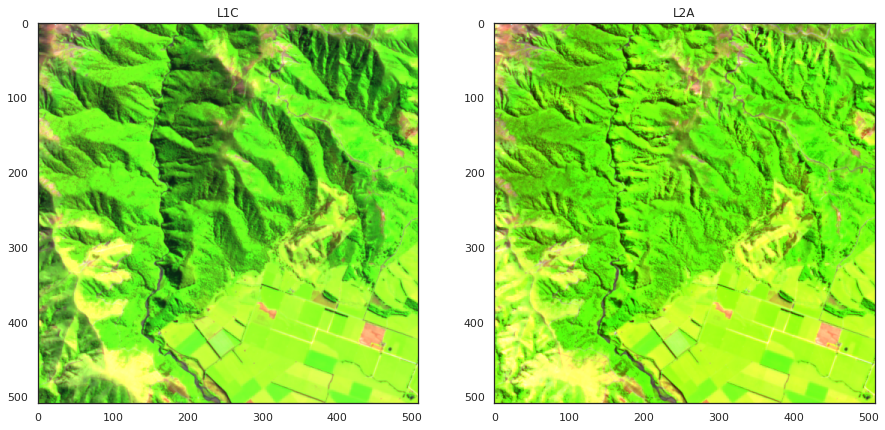

In [32]:
import seaborn as sns
sns.set_theme(style="white")
idx = np.random.randint(0,len(ds_test))
print(idx)
item = ds_test[idx]
item["sl1c"].shape,item["sl2a"].shape

BANDS_RGB = ["B11", "B8", "B4"]

bands_rgb_l1c = [dataset.BANDS_L1C.index(b) for b in BANDS_RGB]
bands_rgb_l2a = [dataset.BANDS_L2A.index(b) for b in BANDS_RGB]

# Poner los canales al final y estirar el rango a 0,0.3 (si no las imágenes se ven muy oscuras)
rgb_l1c = np.array(item["sl1c"])[bands_rgb_l1c,...]
rgb_l1c = np.clip(np.transpose(rgb_l1c, (1,2,0)) / 0.3, 0, 1)

rgb_l2a = np.array(item["sl2a"])[bands_rgb_l2a,...]
rgb_l2a = np.clip(np.transpose(rgb_l2a, (1,2,0)) / 0.3, 0, 1)

fig, ax = plt.subplots(1,2,figsize=(15,7))

ax[0].imshow(rgb_l1c)
ax[0].set_title("L1C")
ax[1].imshow(rgb_l2a)
ax[1].set_title("L2A")

98


Text(0.5, 1.0, 'TOC')

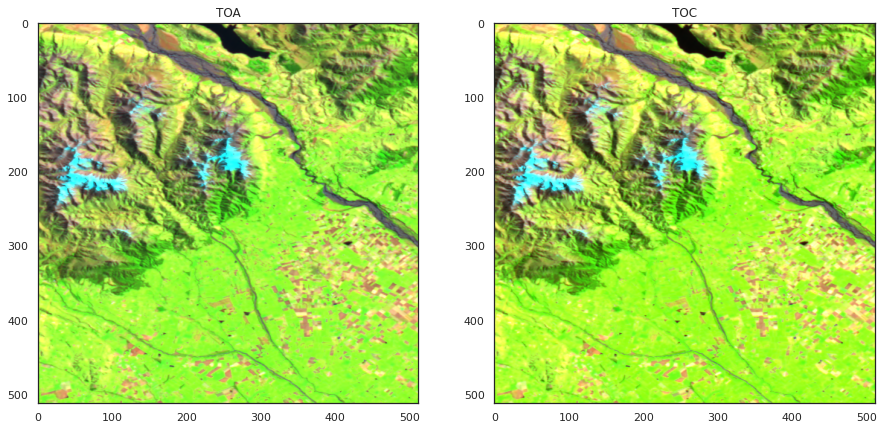

In [33]:
#idx = np.random.randint(0,len(ds_train))
print(idx)
item = ds_pv_test[idx]
item["sl1c"].shape,item["sl2a"].shape

BANDS_RGB = ["B11", "B8", "B4"]

bands_rgb_l1c = [dataset.BANDS_L1C.index(b) for b in BANDS_RGB]
bands_rgb_l2a = [dataset.BANDS_L2A.index(b) for b in BANDS_RGB]

# Poner los canales al final y estirar el rango a 0,0.3 (si no las imágenes se ven muy oscuras)
rgb_l1c = np.array(item["sl1c"])[bands_rgb_l1c,...]
rgb_l1c = np.clip(np.transpose(rgb_l1c, (1,2,0)) / 0.3, 0, 1)

rgb_l2a = np.array(item["sl2a"])[bands_rgb_l2a,...]
rgb_l2a = np.clip(np.transpose(rgb_l2a, (1,2,0)) / 0.3, 0, 1)

fig, ax = plt.subplots(1,2,figsize=(15,7))

ax[0].imshow(rgb_l1c)
ax[0].set_title("TOA")
ax[1].imshow(rgb_l2a)
ax[1].set_title("TOC")

Models

FCNN

In [15]:
class FCNN(nn.Module):

    def __init__(self):
        super(FCNN, self).__init__()
        # Learnable layers
        self.conv1 = nn.Conv2d(in_channels=4, out_channels=32, kernel_size=3, padding=1)
        
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1)
        
        self.conv3 = nn.Conv2d(in_channels=64, out_channels=32, kernel_size=3, padding=1)
        
        self.conv4 = nn.Conv2d(in_channels=32, out_channels=4, kernel_size=5, padding=2)


    def forward(self, x):
        # x.size() = (N, 13, W, W) 
        x = F.relu(self.conv1(x)) 
        # x.size() = (N, 32, W, W) 
        x = F.relu(self.conv2(x))
        # x.size() = (N, 64, W, W)  
        x = F.relu(self.conv3(x))
        # x.size() = (N, 32, W, W)
        x = self.conv4(x)
        # x.size() = (N, 14, W, W)
        return x

In [16]:
model = FCNN()
summary(model, (4, 256, 256))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 32, 256, 256]           1,184
            Conv2d-2         [-1, 64, 256, 256]          18,496
            Conv2d-3         [-1, 32, 256, 256]          18,464
            Conv2d-4          [-1, 4, 256, 256]           3,204
Total params: 41,348
Trainable params: 41,348
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 1.00
Forward/backward pass size (MB): 66.00
Params size (MB): 0.16
Estimated Total Size (MB): 67.16
----------------------------------------------------------------


In [17]:
#Check everything is correct

x = torch.randn((1, 4, 256, 256))
model = FCNN()
preds = model(x)
print(preds.shape)

torch.Size([1, 4, 256, 256])


Train

In [18]:
# initialize our model
model = FCNN()

#If we want to load some model weights:

#model.load_state_dict(torch.load('saved_models/model_train200_val100_e20.pth'))

# initialize loss function and optimizer
lossFunc = MSELoss()
opt = Adam(model.parameters(), lr= 0.001) 

# initialize a dictionary to store training history
H = {"train_loss": [], "val_loss": []}

# select number of epochs
num_epochs = 15


In [25]:
batch_size = 12

df_training = df_train.sample(frac=0.7)
df_val = df_train.loc[~df_train.index.isin(df_training.index)]

window = 256

trainDS = dataset.TiffDataset(df_training, window, False)
valDS = dataset.TiffDataset(df_val, window, False)


trainLoader = DataLoader(trainDS, shuffle=True, batch_size=batch_size)
valLoader = DataLoader(valDS, shuffle=True, batch_size=batch_size)

# calculate steps per epoch for training and test set
trainSteps = len(trainLoader)
valSteps = len(valLoader)

In [26]:
# loop over epochs
train_metrics = []
val_metrics = []


print("[INFO] training the network...")
startTime = time.time()
for e in tqdm(range(num_epochs)):
	# set the model in training mode
	model.train()

	# initialize the total training and validation loss
	totalTrainLoss = 0
	totalValLoss = 0

	# loop over the training set
	for sample in trainLoader:
		# send the input to the device
		x = sample['sl1c']
		y = sample['sl2a']

		# perform a forward pass and calculate the training loss
		pred = model(x)
		train_rad_loss = lossFunc(pred, y)
		loss = train_rad_loss

		
		# first, zero out any previously accumulated gradients, then
		# perform backpropagation, and then update model parameters
		opt.zero_grad()
		loss.backward()
		opt.step()

		# add the loss to the total training loss so far
		totalTrainLoss += loss

	# switch off autograd
	with torch.no_grad():
		# set the model in evaluation mode
		model.eval()

		# loop over the validation set
		for sample in valLoader:
			# send the input to the device
			x = sample['sl1c']
			y = sample['sl2a']

			# make the predictions and calculate the validation loss
			pred = model(x)
			val_rad_loss = lossFunc(pred, y)
			totalValLoss += val_rad_loss

			

	train_rad_loss_np = train_rad_loss.cpu().detach().numpy()
	
	train_metrics.append(train_rad_loss_np)

	val_rad_loss_np = val_rad_loss.cpu().detach().numpy()

	val_metrics.append(val_rad_loss_np)
	
	# calculate the average training and validation loss
	avgTrainLoss = totalTrainLoss / trainSteps
	avgValLoss = totalValLoss / valSteps

	# update our training history
	H["train_loss"].append(avgTrainLoss.cpu().detach().numpy())
	H["val_loss"].append(avgValLoss.cpu().detach().numpy())

	# print the model training and validation information
	print("[INFO] EPOCH: {}/{}".format(e + 1, num_epochs))
	print("Train Loss: {:.6f}, Val Loss: {:.4f}".format(avgTrainLoss, avgValLoss))
    
# display the total time needed to perform the training
endTime = time.time()
print("[INFO] total time taken to train the model: {:.2f}s".format(
	endTime - startTime))

[INFO] training the network...


  7%|█████▎                                                                          | 1/15 [23:24<5:27:37, 1404.11s/it]

[INFO] EPOCH: 1/15
Train Loss: 0.008882, Val Loss: 0.0040


 13%|██████████▋                                                                     | 2/15 [41:09<4:21:00, 1204.67s/it]

[INFO] EPOCH: 2/15
Train Loss: 0.003709, Val Loss: 0.0040


 20%|████████████████                                                                | 3/15 [58:49<3:47:44, 1138.74s/it]

[INFO] EPOCH: 3/15
Train Loss: 0.003968, Val Loss: 0.0054


 27%|████████████████████▊                                                         | 4/15 [1:16:34<3:23:27, 1109.80s/it]

[INFO] EPOCH: 4/15
Train Loss: 0.003505, Val Loss: 0.0029


 33%|██████████████████████████                                                    | 5/15 [1:34:24<3:02:32, 1095.27s/it]

[INFO] EPOCH: 5/15
Train Loss: 0.002471, Val Loss: 0.0033


 40%|███████████████████████████████▏                                              | 6/15 [1:51:54<2:41:59, 1079.97s/it]

[INFO] EPOCH: 6/15
Train Loss: 0.003453, Val Loss: 0.0029


 47%|████████████████████████████████████▍                                         | 7/15 [2:09:42<2:23:28, 1076.08s/it]

[INFO] EPOCH: 7/15
Train Loss: 0.002411, Val Loss: 0.0027


 53%|█████████████████████████████████████████▌                                    | 8/15 [2:27:25<2:05:01, 1071.68s/it]

[INFO] EPOCH: 8/15
Train Loss: 0.002405, Val Loss: 0.0032


 60%|██████████████████████████████████████████████▊                               | 9/15 [2:45:17<1:47:10, 1071.82s/it]

[INFO] EPOCH: 9/15
Train Loss: 0.002440, Val Loss: 0.0027


 67%|███████████████████████████████████████████████████▎                         | 10/15 [3:02:59<1:29:04, 1068.96s/it]

[INFO] EPOCH: 10/15
Train Loss: 0.002167, Val Loss: 0.0024


 73%|████████████████████████████████████████████████████████▍                    | 11/15 [3:20:50<1:11:18, 1069.61s/it]

[INFO] EPOCH: 11/15
Train Loss: 0.002365, Val Loss: 0.0023


 80%|███████████████████████████████████████████████████████████████▏               | 12/15 [3:38:34<53:23, 1067.77s/it]

[INFO] EPOCH: 12/15
Train Loss: 0.002013, Val Loss: 0.0027


 87%|████████████████████████████████████████████████████████████████████▍          | 13/15 [3:56:20<35:34, 1067.33s/it]

[INFO] EPOCH: 13/15
Train Loss: 0.002303, Val Loss: 0.0027


 93%|█████████████████████████████████████████████████████████████████████████▋     | 14/15 [4:14:00<17:45, 1065.14s/it]

[INFO] EPOCH: 14/15
Train Loss: 0.002239, Val Loss: 0.0023


100%|███████████████████████████████████████████████████████████████████████████████| 15/15 [4:31:46<00:00, 1087.09s/it]

[INFO] EPOCH: 15/15
Train Loss: 0.002041, Val Loss: 0.0025
[INFO] total time taken to train the model: 16306.34s


Evaluate predictions

In [ ]:
train_rad=[]

val_rad=[]

for i in range(num_epochs):
    train_rad.append(train_metrics[i])

    val_rad.append(val_metrics[i])
    
train_plots = [train_rad]
val_plots = [val_rad]
titles = 'Radiance'

fig, ax = plt.subplots(1,1,figsize=(20,5))

ax.plot(train_plots[0], label='Train')
ax.plot(val_plots[0], label='Val')
ax.set_title(titles)
ax.legend()
ax.grid('True')

Global metrics

In [21]:
test = dataset.TiffDataset(df_test, 504, False)
idx = np.random.randint(0, len(test))
item = test[idx]
preds = model(torch.reshape(item['sl1c'], (1, item['sl1c'].shape[0], item['sl1c'].shape[1], item['sl1c'].shape[2])))

loss = MSELoss()

BANDS_L2A = ["BLUE", "RED", "NIR", "SWIR"]
methods = ['RMSE', 'PSNR']
rmse_total = 0
psnr_total = 0

for j in range(len(test)):
    item = test[j]
    preds = model(torch.reshape(item['sl1c'], (1, item['sl1c'].shape[0], item['sl1c'].shape[1], item['sl1c'].shape[2])))
    rmse_pred = []
    psnr_pred = []
    for i in range(len(preds[0])):
        rmse = torch.sqrt(loss(preds[0][i], item['sl2a'][i]))
        psnr = 20*torch.log10(torch.max(preds[0][i])/rmse)

        rmse_pred.append(rmse.detach().numpy())
        psnr_pred.append(psnr.detach().numpy())
    
    rmse_total += np.array(rmse_pred)
    psnr_total += np.array(psnr_pred)

RMSE = rmse_total / len(test)
PSNR = psnr_total / len(test)

pd.DataFrame(np.concatenate((RMSE,PSNR)).reshape(2,4), methods, BANDS_L2A)

,BLUE,RED,NIR,SWIR
RMSE,0.031201,0.028238,0.035505,0.024835
PSNR,24.046175,26.756817,26.802273,25.165964


Individual metrics (choose id)

In [22]:
test = dataset.TiffDataset(df_test, 504, False)
idx = np.random.randint(0, len(test))
item = test[idx]
preds = model(torch.reshape(item['sl1c'], (1, item['sl1c'].shape[0], item['sl1c'].shape[1], item['sl1c'].shape[2])))

loss = MSELoss()
rmse_pred = []
psnr_pred = []
BANDS_L2A = ["BLUE", "RED", "NIR", "SWIR"]
methods = ['RMSE', 'PSNR']


for i in range(len(preds[0])):
    rmse = torch.sqrt(loss(preds[0][i], item['sl2a'][i]))
    psnr = 20*torch.log10(torch.max(preds[0][i])/rmse)

    rmse_pred.append(rmse.detach().numpy())
    psnr_pred.append(psnr.detach().numpy())

print('Id:', idx)
pd.DataFrame(np.concatenate((np.array(rmse_pred),np.array(psnr_pred))).reshape(2,4), methods, BANDS_L2A)

Id: 68


,BLUE,RED,NIR,SWIR
RMSE,0.021794,0.013276,0.018330,0.021907
PSNR,19.523542,27.975557,28.311052,28.165243


The following plot displays the ratio between **prediction - real value** of a series of pixels (100) from the test set images and for each band separately.

Text(0.5, 1.0, 'S-2 FCNN: Pixel ratio of predicted vs real values for the test set')

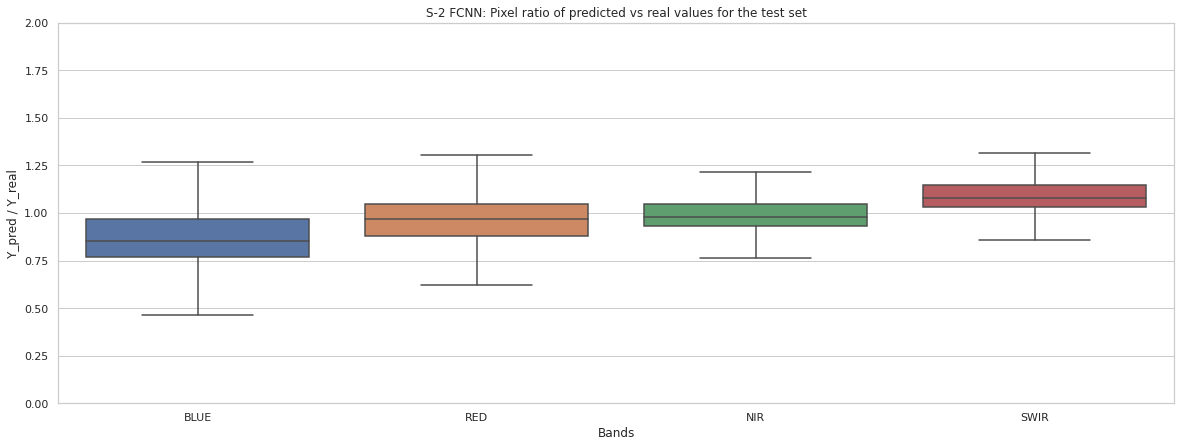

In [23]:
import seaborn as sns
boxplot = {}
boxplot["band"] = []
boxplot["val"] = []
out = np.zeros(preds.shape[1])
samples = 1000

BANDS_L2A = ["BLUE", "RED", "NIR", "SWIR"]

for sample in range(len(test)):
    test = dataset.TiffDataset(df_test, 504, True)
    #id = np.random.randint(0, len(test))
    item = test[sample]
    preds = model(torch.reshape(item['sl1c'], (1, item['sl1c'].shape[0], item['sl1c'].shape[1], item['sl1c'].shape[2])))
    for sample in range(samples):
        idx = np.random.randint(0, preds.shape[2])
        idy = np.random.randint(0, preds.shape[3])
        for band in range(preds.shape[1]):
            if item['sl2a'][band][idx,idy].cpu().detach().numpy() > 0.05:
                boxplot["band"].append(BANDS_L2A[band])
                boxplot["val"].append((preds[0][band][idx,idy].cpu().detach().numpy())/(item['sl2a'][band][idx,idy].cpu().detach().numpy()))
            else:
                out[band] += 1
            


sns.set_theme(style="whitegrid")

fig, ax = plt.subplots(1,1,figsize=(20,7))

ax = sns.boxplot(x=boxplot["band"], y=boxplot["val"], order=BANDS_L2A, showfliers = False)
ax.set_xlabel('Bands')
ax.set_ylabel('Y_pred / Y_real')
ax.set(ylim=(0,2))
ax.set_title('S-2 FCNN: Pixel ratio of predicted vs real values for the test set')

In [24]:
fig.savefig("s2_fcnn_pixel_ratio_test_set.pdf", bbox_inches='tight')

In [25]:
out/(len(test)*samples) #Ratio of samples with real values < 0.05 for each band

array([0.56237, 0.3744 , 0.04231, 0.09757])

18


Text(0.5, 1.0, 'Pixel ratio of predicted vs real values for test image: 18')

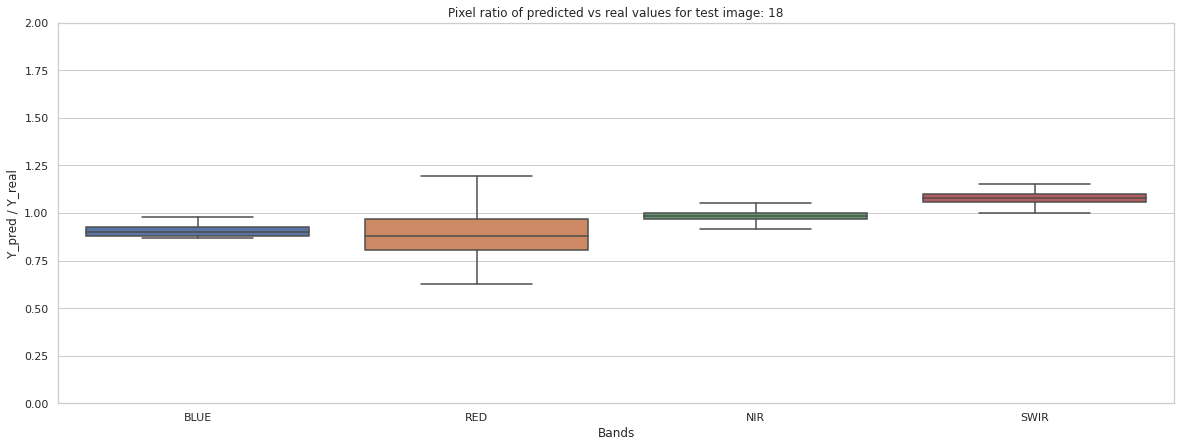

In [143]:
boxplot_2 = {}
boxplot_2["band"] = []
boxplot_2["val"] = []
out_2 = np.zeros(preds.shape[1])
samples = 1000

BANDS_L2A = ["BLUE", "RED", "NIR", "SWIR"]

test = dataset.TiffDataset(df_test, 504, True)
idn = idx #np.random.randint(0, len(test))
print(idn)
item = test[idn]
preds = model(torch.reshape(item['sl1c'], (1, item['sl1c'].shape[0], item['sl1c'].shape[1], item['sl1c'].shape[2])))

for sample in range(samples):
    idx = np.random.randint(0, preds.shape[2])
    idy = np.random.randint(0, preds.shape[3])
    for band in range(preds.shape[1]):
            if item['sl2a'][band][idx,idy].cpu().detach().numpy() > 0.05:
                boxplot_2["band"].append(BANDS_L2A[band])
                boxplot_2["val"].append((preds[0][band][idx,idy].cpu().detach().numpy())/(item['sl2a'][band][idx,idy].cpu().detach().numpy()))
            else:
                out_2[band] += 1
            
sns.set_theme(style="whitegrid")

fig, ax = plt.subplots(1,1,figsize=(20,7))

ax = sns.boxplot(x=boxplot_2["band"], y=boxplot_2["val"], order=BANDS_L2A, showfliers = False)
ax.set_xlabel('Bands')
ax.set_ylabel('Y_pred / Y_real')
ax.set(ylim=(0,2))
ax.set_title('Pixel ratio of predicted vs real values for test image: {}'.format(idn))

In [144]:
fig.savefig("s2_fcnn_pixel_ratio_img_{}.pdf".format(idn), bbox_inches='tight')

In [145]:
out_2/samples #Ratio of samples with real values < 0.05 for each band

array([0.994, 0.217, 0.001, 0.004])

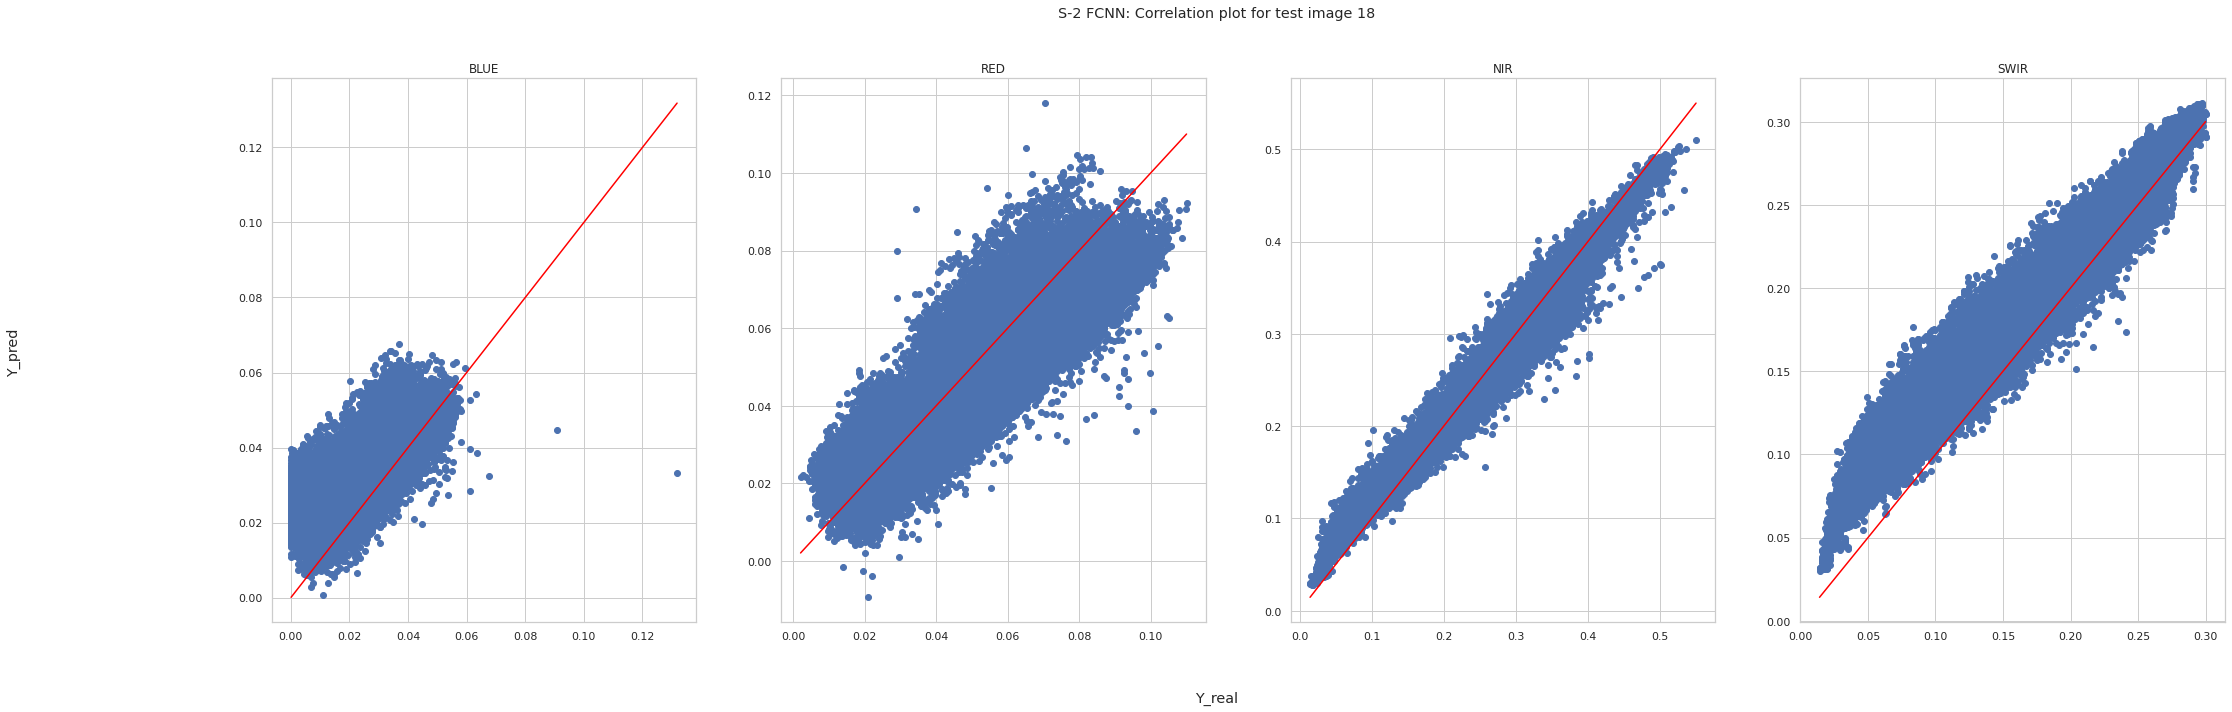

In [146]:
test = dataset.TiffDataset(df_test, 504, False)
#idn = np.random.randint(0, len(test))
item = test[idn]
preds = model(torch.reshape(item['sl1c'], (1, item['sl1c'].shape[0], item['sl1c'].shape[1], item['sl1c'].shape[2])))
            
BANDS_L2A = ["BLUE", "RED", "NIR", "SWIR"]

sns.set_theme(style="whitegrid")
fig, axs = plt.subplots(1,4,figsize=(35,10))
band=1

for band in range(len(BANDS_L2A)):
    axs[band].plot( [item['sl2a'][band].cpu().detach().numpy().min(),item['sl2a'][band].cpu().detach().numpy().max()],[item['sl2a'][band].cpu().detach().numpy().min(),item['sl2a'][band].cpu().detach().numpy().max()], c='red' )
    axs[band].scatter(item['sl2a'][band].cpu().detach().numpy(), preds[0][band].cpu().detach().numpy())
    axs[band].set_title(BANDS_L2A[band])

fig.supxlabel('Y_real')
fig.supylabel('Y_pred')
    

plt.suptitle('S-2 FCNN: Correlation plot for test image {0}'.format(idn))
plt.show()

In [147]:
fig.savefig("fcnn_corr_img_{}.png".format(idn), dpi=50)

Plot predictions

18


Text(0.5, 1.0, 'Pred')

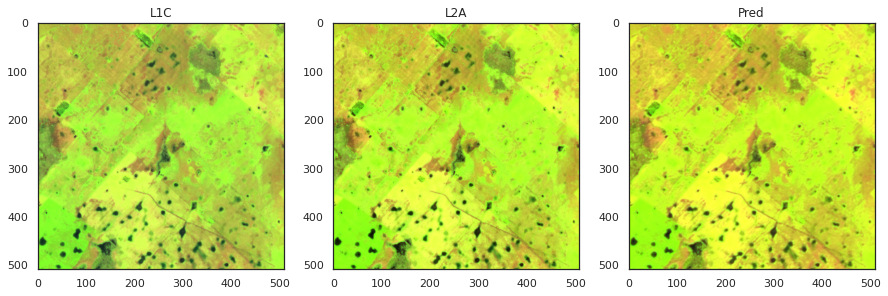

In [148]:
sns.set_theme(style="white")

test = dataset.TiffDataset(df_test, 504, False)
idx =  18 #np.random.randint(0, len(test))
print(idx)
item = test[idx]
preds = model(torch.reshape(item['sl1c'], (1, item['sl1c'].shape[0], item['sl1c'].shape[1], item['sl1c'].shape[2])))

BANDS_RGB = ["B11", "B8", "B4"]

bands_rgb_l1c = [dataset.BANDS_L1C.index(b) for b in BANDS_RGB]
bands_rgb_l2a = [dataset.BANDS_L2A.index(b) for b in BANDS_RGB]

# Poner los canales al final y estirar el rango a 0,0.3 (si no las imágenes se ven muy oscuras)
rgb_l1c = np.array(item["sl1c"])[bands_rgb_l1c,...]
rgb_l1c = np.clip(np.transpose(rgb_l1c, (1,2,0)) / 0.3, 0, 1)

rgb_l2a = np.array(item["sl2a"])[bands_rgb_l2a,...]
rgb_l2a = np.clip(np.transpose(rgb_l2a, (1,2,0)) / 0.3, 0, 1)

predic = preds.detach().numpy()[0][[3,2,1] ,:,:]
predic = np.clip(np.transpose(predic, (1,2,0)) / 0.3, 0, 1)

fig, ax = plt.subplots(1,3,figsize=(15,7))

ax[0].imshow(rgb_l1c)
ax[0].set_title("L1C")

ax[1].imshow(rgb_l2a)
ax[1].set_title("L2A")
ax[2].imshow(predic)
ax[2].set_title("Pred")

In [149]:
fig.savefig("plot_prediction_{}.pdf".format(idx), bbox_inches='tight')

In [1]:
#model_save = {'state_dict': model.state_dict(), 'lr': 0.001}

#torch.save(model_save, 'saved_models/fcnn_s2_4bands.pth')

Load previously saved model weights

In [19]:
model.load_state_dict(torch.load('saved_models/fcnn_s2_4bands.pth')['state_dict'])

<All keys matched successfully>